In [19]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])
training_data, test_data = torch.utils.data.random_split(training_data, [40000, 10000])
train_dataloader = DataLoader(training_data, batch_size=64)
validation_dataloader = DataLoader(validation_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)


Using cpu device


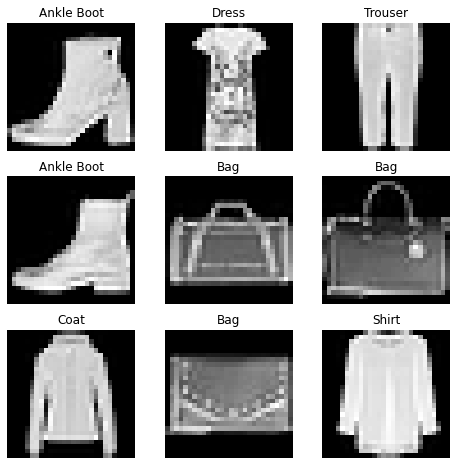

In [20]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self,n_neurons=512,input_dim=28*28,output_dim=10):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, n_neurons),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(n_neurons, n_neurons),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(n_neurons, output_dim),
            
        )
        #self.softmax=nn.Softmax()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        #output=self.softmax(x)  Softmax is not needed only because pytorch does this with cross entropy loss automatically
        return x

model = NeuralNetwork(n_neurons=512)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [26]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
def fit_one_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            #print(f"loss: {loss}  [{current}/{size}]")


def predict_dataset(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
def predict(data,model,apply_softmax=True):
    labels=data[1]
    label=labels[0] #Take first element of batch
    data=data[0]  
    data=data[0,:,:,:] #Take first element of batch
    print(f"Size of one sample is {data.size()}") #First dimension is 1 because image is black & white. Would be 3 for RGB.
    pred = model(data)
    if apply_softmax:
        softmax=nn.Softmax()
        pred=softmax(pred)
    pred=pred.detach().numpy()
    pred=pred[0]
    print(f"Predicted label probabilities for first image: {pred*100}")
    print(f"True label for first image is {label.numpy()}")

In [28]:

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    fit_one_epoch(train_dataloader, model, loss_fn, optimizer)
    print('Validation results:')
    predict_dataset(validation_dataloader, model, loss_fn)
print('Test results:')
predict(next(iter(test_dataloader)),model,loss_fn)
predict_dataset(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
Validation results:
Error: 
 Accuracy: 31.52%, Avg loss: 2.2218395843627348 

Epoch 2
-------------------------------
Validation results:
Error: 
 Accuracy: 38.68%, Avg loss: 2.114220124141426 

Epoch 3
-------------------------------
Validation results:
Error: 
 Accuracy: 46.29%, Avg loss: 1.9461871074263457 

Epoch 4
-------------------------------
Validation results:
Error: 
 Accuracy: 51.690000000000005%, Avg loss: 1.7210367766155559 

Epoch 5
-------------------------------
Validation results:
Error: 
 Accuracy: 55.55%, Avg loss: 1.5050070764152867 

Epoch 6
-------------------------------
Validation results:
Error: 
 Accuracy: 57.95%, Avg loss: 1.3441213900875892 

Epoch 7
-------------------------------
Validation results:
Error: 
 Accuracy: 60.57%, Avg loss: 1.2152859116815458 

Epoch 8
-------------------------------
Validation results:
Error: 
 Accuracy: 61.6%, Avg loss: 1.1258321886609315 

Epoch 9
-------------------------------
Valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Error: 
 Accuracy: 64.24%, Avg loss: 0.9993517827835812 



* Compared to no dropout layer (Epoch 10: 67.66%) it get worse validation accuracy (Epoch 10: 64.29%) with dropout layers.